## Imports from standard packages

In [4]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits

## Local imports

In [138]:
from extract.overlap import TrpzOverlap
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Simulations inputs

In [141]:
scale_flux = 1e2

tilt = True

# Main kwargs for simulation
overlap_kwargs = {"n_os": 15,
                  "thresh": 1e-8}
# Convolution kwargs
c_kwargs = {"thresh": 1e-6}

# Output file
output_file = f"../Simulations/phoenix_teff_09000_scale_{scale_flux:.1e}_vsini_5.fits"

### Use interpolated PHOENIX spectrum

In [124]:
path = "/Users/antoinedb/Documents/Doctorat/SOSS/"
model_file = "Z-0.0-lte09000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-n_os-15.npz"
spec_file = np.load(path+model_file)

In [125]:
wv, flux = spec_file["wave"], spec_file["flux"]
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
flux *= scale_flux

flux_interp = interp1d(wv, flux, kind="cubic", bounds_error=False, fill_value=0.)

In [129]:
ker = KerVsini(5, wv)
# plt.plot(wv[:40000], flux[:40000])

d_i_wv = 5000
pad = 500
flux_vsini = np.ma.masked_all_like(flux)
for i_wv in np.arange(0, len(wv), d_i_wv):
    print(i_wv, end='\r')
    
    i_min = np.max([i_wv - pad, 0])
    i_max = np.min([i_wv + d_i_wv + pad, len(wv)])
    
    index = slice(i_min, i_max)
    
    f_out = np.ma.masked_all_like(flux)
    
    # Build convolution matrix
    i_bounds = np.array([None, None])
    out_index = np.array([None, None])
    if (i_min == 0):
        i_bounds[0] = 0
        out_index[0] = 0
    else:
        i_bounds[0] = pad
        out_index[0] = i_min + pad
        
    if (i_max == len(wv)):
        i_bounds[1] = len(wv)
        out_index[1] = len(wv)
    else:
        i_bounds[1] = -pad + 1
        out_index[1] = i_max - pad + 1
        
    conv_vsini = get_c_matrix(ker, wv[index], thresh=1e-3, n_out=pad, i_bounds=i_bounds)
    f_out[slice(*out_index)] = conv_vsini.dot(flux[index])
    flux_vsini = np.ma.mean([f_out, flux_vsini], axis=0)
#     plt.plot(wv, f_out)
    
flux_vsini = flux_vsini.data

ValueError: operands could not be broadcast together with shapes (642,) (0,) 

<IPython.core.display.Javascript object>


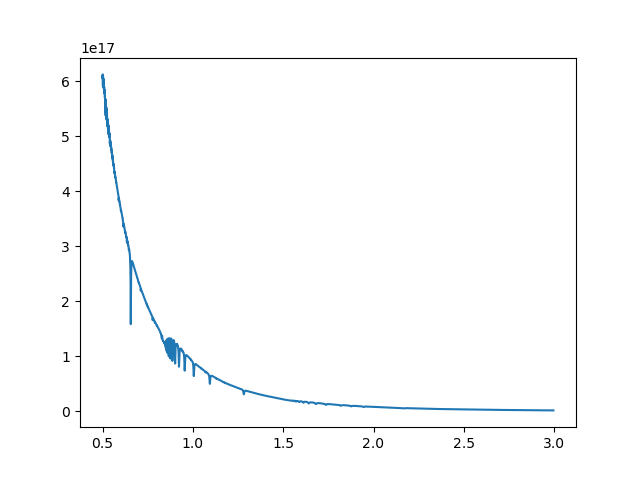

In [145]:
# plt.plot(wv, flux)
plt.plot(wv, flux_vsini)

In [132]:
flux_vsini[~flux_vsini.mask].data

array([6.08643804e+17, 6.08480238e+17, 6.08317234e+17, ...,
       1.83366250e+15, 1.83365570e+15, 1.83364895e+15])

In [133]:
flux_interp = interp1d(wv[~flux_vsini.mask], flux_vsini[~flux_vsini.mask].data, kind="cubic", bounds_error=False, fill_value=0.)

# Simulations

In [139]:
# List of orders to consider in the extraction
order_list = [1, 2]

path = "../jwst-mtl/SOSS/extract/Ref_files/"

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata(path + "wavelengths_m1.fits"))
wave_maps.append(fits.getdata(path + "wavelengths_m2.fits"))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata(path + "spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata(path + "spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]

#### Convolution kernels ####
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

In [140]:
# # Read relevant files
# wv_1 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/wavelengths_m1.fits")[0].data
# wv_2 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/wavelengths_m2.fits")[0].data
# P1 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/spat_profile_m1.fits")[0].data.squeeze()
# P2 = fits.open("../jwst-mtl/SOSS/extract/Ref_files/spat_profile_m2.fits")[0].data.squeeze()

# # Convert to float (fits precision is 1e-8)
# wv_1 = wv_1.astype(float)
# wv_2 = wv_2.astype(float)
# P1 = P1.astype(float)
# P2 = P2.astype(float)

# if not tilt:
#     # Remove the tilt from wv maps
#     wv_1 = np.tile(wv_1[50,:], (256, 1))
#     wv_2 = np.tile(wv_2[50,:], (256, 1))
    

#### Initiate a simulation ####
simu = TrpzOverlap(*ref_files_args, c_kwargs=c_kwargs, **overlap_kwargs)
# simu = TrpzOverlap([P1,P2], [wv_1,wv_2], c_kwargs=c_kwargs, **overlap_kwargs)

### Inject spectrum

# Generate flux to inject
flux = flux_interp(simu.lam_grid)

# Init outputs
out_ord = [{} for i in range(simu.n_ord)]
out_full = {}

# Inject order 1 and 2 separately (we don't want any contamination here)
for i_ord in range(simu.n_ord):
    out_ord[i_ord]["data"] = simu.rebuild(flux, orders=[i_ord])

# Inject both orders (full)
out_full["data"] = simu.rebuild(flux)

## Add noise

In [142]:
from simulation_utils import add_noise

for out_dict in out_ord:
    out_dict["noisy"] = add_noise(out_dict["data"])

out_full["noisy"] = add_noise(out_full["data"])

# Save full simu and for each orders separately

In [143]:
hdr = fits.Header()
for key in overlap_kwargs:
    hdr[key.upper()] = overlap_kwargs[key]
    
for key in c_kwargs:
    hkey = "C_" + key.upper()
    hdr[hkey] = c_kwargs[key]

hdr["TILTED"] = tilt

# Save headers
primary_hdu = fits.PrimaryHDU(header=hdr)
hdul = fits.HDUList([primary_hdu])

# Save flux
col_list = []
col_list.append(fits.Column(name="lam_grid", array=simu.lam_grid, format="D"))
col_list.append(fits.Column(name='f_lam', array=flux, format='D'))
table_hdu = fits.BinTableHDU.from_columns(col_list, name='FLUX')
hdul.append(table_hdu)

for i_ord, out in enumerate(out_ord):
    name = f"FLUX_C{simu.orders[i_ord]}"
    x = simu.lam_grid_c(i_ord)
    y = simu.c_list[i_ord].dot(flux)
    col_list = []
    col_list.append(fits.Column(name='lam_grid', array=x, format='D'))
    col_list.append(fits.Column(name='f_lam', array=y, format='D'))
    table_hdu = fits.BinTableHDU.from_columns(col_list, name=name)
    hdul.append(table_hdu)

# Save detector simu
hdul.append(fits.ImageHDU(out_full["data"], name="FULL"))
hdul.append(fits.ImageHDU(out_full["noisy"], name="FULL NOISY"))
for i_ord, out in enumerate(out_ord):
    name = f"ORD {simu.orders[i_ord]}"
    hdul.append(fits.ImageHDU(out["data"], name=name))
    hdul.append(fits.ImageHDU(out["noisy"], name=name + " NOISY"))
    
# Write to file
hdul.writeto(output_file)